In [8]:
import cv2 as cv # import our image proccesing dataset 
import numpy as np 
import os 
#visualization library 

import matplotlib.pyplot as plt
 
#import our model prediction libraries 
import tensorflow as tf
from tensorflow.keras.layers import Dense , Conv2D ,MaxPooling2D ,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import linear ,sigmoid,relu
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

First of all we should make a list from our images 

I have already made our dataframe 11 times bigger using add data file.
 you can take a look and see the code itself  

 i recommend that you dont run the add data file because it makes the data frame 11 time bigger anf those datas are not so valuable the second time that they come out of the code 

In [3]:


possible_conditions=['Blight tomato leaf' , 'Healthy tomato leaf']
picture = []
condition= []
link = 'dataset'
for possible_condition in possible_conditions:
    folder_path = os.path.join(link, possible_condition)
    
    for img in os.listdir(folder_path):
        dir =os.path.join(folder_path , img)
        added_picture =cv.imread(dir)
        
        picture.append(added_picture)
        if possible_condition == 'Blight tomato leaf': condition.append(0)
        else:condition.append(1)
        

Lets see if it really works or not 

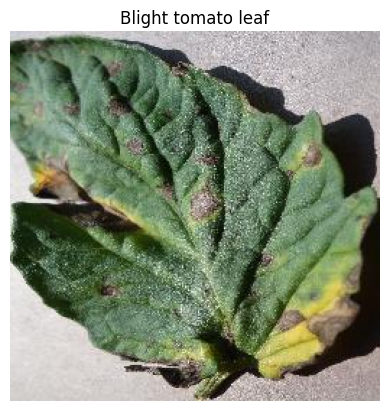

(256, 256, 3)


In [4]:

plt.imshow(cv.cvtColor(picture[1], cv.COLOR_BGR2RGB))
plt.title(possible_conditions[condition[1]])
plt.axis('off')
plt.show()
print(picture[1].shape)

We should make the pictures in same shape 

we can see what shape is best for our images from the current shapes 
then we are gonna normalize it to make the machine work faster 

In [5]:
reshaped_picture =[]
for pic in picture:
    pic = cv.resize(pic, (256, 256))
    reshaped_picture.append(pic)

reshaped_picture_array = np.array(reshaped_picture)
reshaped_picture_array = reshaped_picture_array/255.0

y= np.array(condition)

In [6]:
np.save('pictures.npy',reshaped_picture_array)
np.save('conditions.npy',y)

In [7]:
x_train , x_, y_train, y_ = train_test_split(reshaped_picture_array ,y,test_size=0.4,random_state=42)
x_test, x_cv , y_test , y_cv = train_test_split(x_ , y_ , test_size=0.5,random_state=42)
del x_ , y_
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

if you dont want to train the model you can use this box of code and skip next two boxes.


In [10]:

from tensorflow.keras.models import load_model


def evaluate_model(model_path, x_train, y_train, x_test, y_test, x_cv, y_cv):
    # Load the model from the .keras file
    model = load_model(model_path)
    
    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Predict on the cross-validation set and calculate the cross-validation loss
    y_cv_pred = model.predict(x_cv)
    cv_loss = mean_squared_error(y_cv, y_cv_pred)
    print(f"Cross-Validation Loss: {cv_loss}")
    
    # Store the losses in a dictionary
    losses = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'cv_loss': cv_loss
    }
    
    return losses





In [12]:
model_path = 'model1.keras'
model_1 =load_model(model_path)
losses_1 = evaluate_model(model_path, x_train, y_train, x_test, y_test, x_cv, y_cv)

model_path = 'model2.keras'
model_2 =load_model(model_path)
losses_2 = evaluate_model(model_path, x_train, y_train, x_test, y_test, x_cv, y_cv)

model_path = 'model4.keras'
model_4 =load_model(model_path)
losses_4 = evaluate_model(model_path, x_train, y_train, x_test, y_test, x_cv, y_cv)


Train Loss: 0.03218049928545952, Train Accuracy: 0.9953216314315796
Test Loss: 0.0573752298951149, Test Accuracy: 0.980701744556427
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step
Cross-Validation Loss: 0.01338853475236481
Train Loss: 0.0830082818865776, Train Accuracy: 0.9643275141716003
Test Loss: 0.12811341881752014, Test Accuracy: 0.9561403393745422
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step
Cross-Validation Loss: 0.04587468877132504
Train Loss: 0.036266740411520004, Train Accuracy: 0.9859648942947388
Test Loss: 0.05161469429731369, Test Accuracy: 0.9789473414421082
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step
Cross-Validation Loss: 0.0196015434385191


In [23]:
models = [model_1,model_2,model_4]
accuracy =[]
best_model=None
best_accuracy =0
for model in models:
    model_accuracy = model.evaluate(x_test,y_test,verbose =0)[1]
    accuracy.append(model_accuracy)
    if model_accuracy >best_accuracy :
        best_accuracy=model_accuracy
        best_model=model
    

In [15]:
loss = [losses_1['train_loss'], losses_2['train_loss'], losses_4['train_loss']]

test_loss = [losses_1['test_loss'], losses_2['test_loss'], losses_4['test_loss']]

cv_loss = [losses_1['cv_loss'], losses_2['cv_loss'], losses_4['cv_loss']]

now we can start to build our prediction system 
i have commented the third one because it was taking so much space . you can uncomment it if you want 

In [8]:
model_1 = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
], name='model_1')

model_2 = Sequential([
    Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
], name='model_2')

'''model_3 = Sequential([
    Conv2D(64,(4,4),activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(128,(4,4),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(4,4),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
], name='model_3')'''

model_4 = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(4,4),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(5,5),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
], name='model_4')

models = [model_1, model_2,  model_4]
#model_3,


c:\Users\a2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We will chose the best model from these models in terms of accuracy and prevent overfitting .

It will take a while 

In [11]:
loss = []
test_loss = []
cv_loss =[]

accuracy = []

best_model = None
best_accuracy = 0

for model in models:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    yhat = model.predict(x_train)
    loss.append(mean_squared_error(yhat, y_train))
    
    yhat = model.predict(x_test)
    test_loss.append(mean_squared_error(yhat, y_test))
    
    yhat = model.predict(x_cv)
    cv_loss.append(mean_squared_error(yhat, y_cv))
    
    acc = model.evaluate(x_test, y_test, verbose=0)[1]  # Extract accuracy from the list
    accuracy.append(acc * 100)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

print(f'best model : {best_model.name} accuracy : {best_accuracy * 100:.2f}%')
    




Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7587 - loss: 0.9727
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9441 - loss: 0.1626
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9663 - loss: 0.1068
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9820 - loss: 0.0624
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9823 - loss: 0.0583
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9747 - loss: 0.0775
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9918 - loss: 0.0192
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9956 - loss: 0.0132
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9942 - loss: 0.0131
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9508 - loss: 0.1931
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━

We will save our model so there is no need to train the model again

In [18]:
import pandas as pd

# Create a DataFrame from the metrics
data = {
	'Model': [model.name for model in models],
	'Accuracy': accuracy,
	'Test Loss': test_loss,
	'Train Loss': loss,
	'CV Loss': cv_loss
}

df_metrics = pd.DataFrame(data)
df_metrics

,Model,Accuracy,Test Loss,Train Loss,CV Loss
0,model_1,0.980702,0.057375,0.032180,0.013389
1,model_2,0.956140,0.128113,0.083008,0.045875
2,model_4,0.978947,0.051615,0.036267,0.019602


lets plot them to have a better understanding 

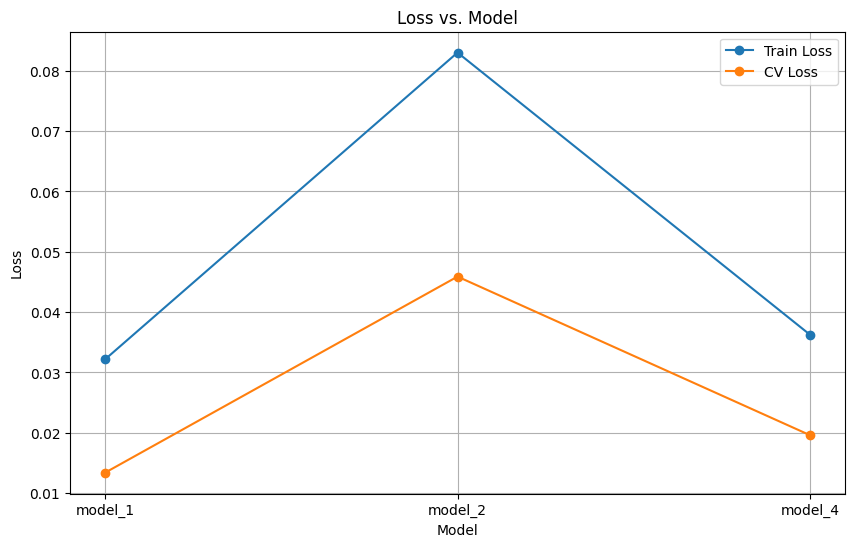

In [20]:
data = {
    'Model': [model.name for model in models],
    'Accuracy': accuracy,
    'Test Loss': test_loss,
    'Train Loss': loss,
    'CV Loss': cv_loss
}

df_metrics = pd.DataFrame(data)

# Plot the chart
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['Model'], df_metrics['Train Loss'], marker='o', label='Train Loss')

plt.plot(df_metrics['Model'], df_metrics['CV Loss'], marker='o', label='CV Loss')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss vs. Model')
plt.legend()
plt.grid(True)
plt.show()

as you can see the model 1 is the best model becauseit has the best accuracy , its loss function is the lowest and train loss and cv loss are close to eachother . 

and for last step, we will define a function that predicts a new picture

In [28]:


def test(link):
    pic = cv.imread(link)
    reshaped_pic = cv.resize(pic, (256, 256))
    reshaped_pic = np.array(reshaped_pic)
    reshaped_pic = reshaped_pic / 255.0
    
    # Add a batch dimension to the input image
    reshaped_pic = np.expand_dims(reshaped_pic, axis=0)
    
    prediction = best_model.predict(reshaped_pic)
    
    if prediction >= 0.90:
        prediction = 1
    else:
        prediction = 0
    
    plt.imshow(cv.cvtColor(pic, cv.COLOR_BGR2RGB))
    plt.title(possible_conditions[prediction])
    plt.axis('off')
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


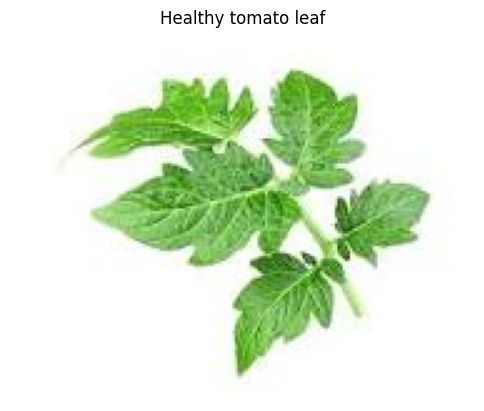

In [29]:
test('final test healthy.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


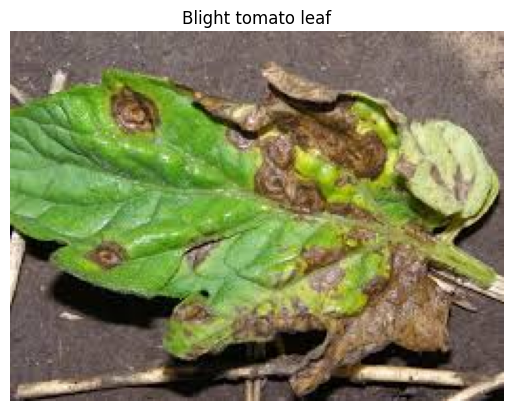

In [30]:
test('final test blight.jpg')

Well. as you can see our model is working so well you can try other images if you want to